## Introduction
We are ready to train the Cardiac Detection Model now!

## Imports:

* torch and torchvision for model and dataloader creation
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* numpy data loading
* cv2 for drawing rectangles on images
* imgaug for augmentation pipeline
* Our CardiacDataset



In [37]:
import sys
from pathlib import Path
BASE_DIR = Path.cwd().parent
sys.path.append(BASE_DIR / "scripts")
from dataset import CardiacDataset

import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import cv2
import imgaug.augmenters as iaa



We define the paths for the training and validation datasets and create a basic augmentation pipeline using `imgaug.Sequential`. The augmentations applied include:

- Gamma contrast adjustment
- Random scaling, rotation, and translation

These transformations help to artificially increase the diversity of the training data, improving model robustness.

In [38]:
train_root_path = BASE_DIR / "data" / "processed" / "train"
train_subjects = BASE_DIR / "data" / "processed" / "train_subjects_det.npy"
val_root_path = BASE_DIR / "data" / "processed" / "val"
val_subjects = BASE_DIR / "data" / "processed" / "val_subjects_det.npy"

train_transforms = iaa.Sequential([
                                iaa.GammaContrast(),
                                iaa.Affine(
                                    scale=(0.8, 1.2),
                                    rotate=(-10, 10),
                                    translate_px=(-10, 10)
                                )
                            ])

We instantiate two `CardiacDataset` objects:
- One for training, with augmentations applied.
- One for validation, without augmentations.

Each dataset loads images and corresponding bounding box labels from the preprocessed data and the CSV file.

In [39]:
train_dataset = CardiacDataset(BASE_DIR / "resources" / "rsna_heart_detection.csv", train_subjects, train_root_path, train_transforms)
val_dataset = CardiacDataset(BASE_DIR / "resources" / "rsna_heart_detection.csv", val_subjects, val_root_path, None)

In our setup, we train the model by executing a standalone Python script (`train.py`), not inside this notebook.  
This allows us to take full advantage of multiprocessing for faster data loading — specifically by setting `num_workers = 8` when running on Windows.

However, notebooks (such as Jupyter or IPython environments) don't handle multiprocessing well with PyTorch's DataLoader.  
To prevent issues like deadlocks or infinite loops during development or validation, we check whether the code is running inside a notebook using the `is_notebook()` helper function.

If we detect a notebook environment, we disable multiprocessing by setting:
- `num_workers = 0`
- `persistent_workers = False`

When running the actual training via `train.py`, this check will evaluate to `False`, enabling efficient multi-worker loading.

In short:
- **Training is done via script** for speed (8 workers).
- **Evaluation and exploration** are done in this notebook (0 workers for compatibility).

In [40]:
import os
import sys

In [41]:
def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        return shell == "ZMQInteractiveShell"
    except NameError:
        return False

In [42]:
# Use more workers if safe (e.g. script, not notebook)
if os.name == 'nt' and not is_notebook():
    num_workers = min(8, os.cpu_count())  # Use up to 8 workers safely
    persistent_workers = True
else:
    num_workers = 0
    persistent_workers = False

We wrap both datasets with PyTorch `DataLoader` objects to efficiently batch and serve data during training and validation.

- `train_loader` uses `shuffle=True` to randomize the order of training samples in each epoch.
- `val_loader` uses `shuffle=False` to ensure consistent evaluation.

In [43]:
batch_size = 8


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


## Model Creation

### Defining the cardiac detection model (LightningModule)

We define our model by subclassing `pytorch_lightning.LightningModule`, which provides a clean structure for training, validation, logging, and saving models.

Below is a detailed explanation of how the model behaves throughout the training process:

---

#### 1. `__init__`: Model initialization

The constructor is executed **once at the beginning**, when the model is instantiated.

Here we define:
- A pretrained ResNet18 as the backbone, with modifications:
  - The first convolution layer is adapted to accept grayscale images (`1` channel).
  - The final fully connected layer is replaced to output 4 values corresponding to the bounding box coordinates: `[x0, y0, x1, y1]`.
- The optimizer used is **Adam**, with a learning rate of `1e-4`.
- The loss function is **Mean Squared Error (MSE)**, as we're performing bounding box regression.
- Two lists to store training and validation losses per epoch (`train_losses`, `val_losses`).

---

#### 2. `forward`: Inference logic

Defines how a batch of data flows through the model.  
Called internally during training, validation, or manual inference.

---

#### 3. `training_step`: Runs once per training batch

This is executed **many times per epoch**, once per batch.

What it does:
- Receives a batch `(x_ray, label)` from the `train_loader`.
- Computes model predictions and the loss.
- Logs the batch loss under the name `"train_loss"`.
- Every 50 batches, it logs visual predictions using `self.log_images()`.

Returns:
- A dictionary with the loss that will be used later in `training_epoch_end`.

---

#### 4. `training_epoch_end`: Runs once per training epoch

After all batches in an epoch have been processed, this method is called.

It:
- Computes the average training loss for the epoch.
- Logs it as `"avg_train_loss"` for monitoring.
- Appends it to the internal list `self.train_losses` for later export.

---

#### 5. `validation_step`: Runs once per validation batch

Analogous to `training_step`, but for the validation set.

- Uses the same loss function (MSE).
- Logs `"val_loss"` and visual predictions every 50 batches.
- Returns a dictionary with the loss, for use in `validation_epoch_end`.

---

#### 6. `validation_epoch_end`: Runs once per validation epoch

After all validation batches are processed:
- Computes the average validation loss.
- Logs it as `"avg_val_loss"`.
- Stores it in `self.val_losses` for metric tracking.

This is the value used by the `ModelCheckpoint` callback to save the best model.

---

#### 7. `log_images`: Visual logging to TensorBoard

This helper method draws both the **ground truth** and **predicted** bounding boxes on the images, then logs them to TensorBoard.

Details:
- Only logs the first 4 images in the batch (or fewer if batch size is small).
- Uses black for ground truth, white for predictions.

---

#### 8. `configure_optimizers`: Returns the optimizer

PyTorch Lightning calls this to set up training.  
We simply return a list with the Adam optimizer defined earlier.

---

#### 9. `save_metrics`: Exporting epoch-level metrics

After training, we call this method to export the collected metrics (`train_loss`, `val_loss`) to a `.csv` file.

To avoid errors due to unequal lengths (e.g., if training stopped early), we truncate both lists to the shortest one.


In [44]:
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        # Load pretrained ResNet18 and adapt it
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)

        # Optimizer and loss
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()

        # Tracking losses per epoch
        self.train_losses = []
        self.val_losses = []

    def forward(self, data):
        return self.model(data)

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        self.log("train_loss", loss)

        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")

        return {"loss": loss}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.log("avg_train_loss", avg_loss, prog_bar=True)
        self.train_losses.append(avg_loss.item())

    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        self.log("val_loss", loss)

        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")

        return {"loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.log("avg_val_loss", avg_loss, prog_bar=True)
        self.val_losses.append(avg_loss.item())

    def log_images(self, x_ray, pred, label, name):
        results = []
        for i in range(min(4, x_ray.size(0))):  # Protect against batches smaller than 4
            coords_labels = label[i]
            coords_pred = pred[i]
            img = ((x_ray[i] * 0.252) + 0.494).numpy()[0]

            # Draw ground truth bbox
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)

            # Draw predicted bbox
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)

            results.append(torch.tensor(img).unsqueeze(0))

        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(f"{name} Prediction vs Label", grid, self.global_step)

    def configure_optimizers(self):
        return [self.optimizer]

    def save_metrics(self, filename="training_metrics.csv"):
    import pandas as pd

    # Ensure all lists have the same length
    min_len = min(len(self.train_losses), len(self.val_losses))

    df = pd.DataFrame({
        "epoch": list(range(min_len)),
        "train_loss": self.train_losses[:min_len],
        "val_loss": self.val_losses[:min_len]
    })
    df.to_csv(filename, index=False)

IndentationError: expected an indented block (Temp/ipykernel_20612/3844955158.py, line 81)

We now prepare and launch the training process. This involves:

- **Instantiating the model** and moving it to the GPU.
- **Defining a ModelCheckpoint callback** to automatically save the best model based on `avg_val_loss`.
- **Creating the Trainer**, which controls the training loop, logging, and checkpointing.
- **Starting the training** with `trainer.fit(...)`, using the defined dataloaders.

The training runs for 100 epochs, and logs can be visualized using TensorBoard.

In [45]:
# Create the model object
model = CardiacDetectionModel().to("cuda")  # Instanciate the model

C:\Users\demonki\anaconda3\envs\pytorchenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\demonki\anaconda3\envs\pytorchenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
checkpoint_callback = ModelCheckpoint(
    monitor="avg_val_loss",        # Monitorea la pérdida de validación promedio
    mode="min",                    # Queremos minimizar la val_loss
    save_top_k=1,                  # Solo guarda el mejor modelo
    dirpath=BASE_DIR / "models",   # Carpeta donde guardar el modelo
    filename="best-cardiac-detection",  # Nombre base del archivo
    save_last=True                 # Opcional: también guarda el último modelo
)


C:\Users\demonki\anaconda3\envs\pytorchenv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:446: UserWarning: Checkpoint directory E:\ESTUDIOS\CursoUdemyAIMedicalImages\AI-IN-MEDICAL-MATERIALS\05-Detection\models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


In [47]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training

trainer = pl.Trainer(
    gpus=1,
    logger=TensorBoardLogger(BASE_DIR / "logs", name="cardiac_detection"),
    default_root_dir=BASE_DIR / "models",
    callbacks=[checkpoint_callback],
    max_epochs=100
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [48]:
# Train the detection model
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | model   | ResNet  | 11.2 M
1 | loss_fn | MSELoss | 0     
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\demonki\anaconda3\envs\pytorchenv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\demonki\anaconda3\envs\pytorchenv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

C:\Users\demonki\anaconda3\envs\pytorchenv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1051: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Evaluation

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


We load the best model checkpoint saved during training and set it to evaluation mode.  
We also export the recorded training and validation losses to a CSV file for further analysis.

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CardiacDetectionModel.load_from_checkpoint(BASE_DIR / "models" / "best-cardiac-detection.ckpt")
model.eval();
model.to(device)
model.save_metrics(BASE_DIR / "models" / "training_metrics.csv")

We iterate over the validation dataset and store both the predicted and ground truth bounding boxes.

Each prediction consists of 4 continuous values:
- `[x0, y0, x1, y1]`, representing the top-left and bottom-right corners of the predicted bounding box.

Unlike typical classification tasks, here the model outputs a coordinate-based regression result.  
This makes it especially important to compare predictions visually and evaluate how closely the predicted box overlaps the true one.

In [32]:
preds = []
labels = []

with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)
        
preds=torch.stack(preds)
labels=torch.stack(labels)

This line gives us the average pixel distance between the predicted and true values for each of those four coordinates — giving a precise measure of how far off the predicted box is, per side.

In [33]:
abs(preds-labels).mean(0)

tensor([4.0121, 4.1161, 4.5524, 5.4934])

This allows us to inspect a specific image and compare its predicted and ground truth bounding boxes.

- Retrieves the image and true bounding box from the dataset.
- Retrieves the corresponding predicted bounding box from the previously computed predictions.
- Uses matplotlib to display the image and overlay the predicted bounding box in red.

The red rectangle shows the model’s predicted location of the heart.
By changing IDX, we can manually inspect how well the model is performing across different samples.

tensor([ 52,  65, 135, 180])


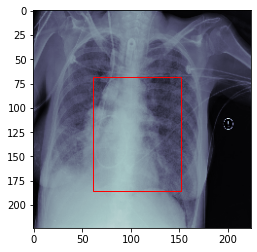

In [36]:
IDX = 41  # Feel free to inspect all validation samples by changing the index
img, label = val_dataset[IDX]
current_pred = preds[IDX]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
heart = patches.Rectangle((current_pred[0], current_pred[1]), current_pred[2]-current_pred[0],
                          current_pred[3]-current_pred[1], linewidth=1, edgecolor='r', facecolor='none')
axis.add_patch(heart)

print(label)

### Visualizing training results with TensorBoard

To explore the training progress interactively, you can launch TensorBoard by running the following command from your project directory:

tensorboard --logdir=logs/cardiac_detection

This will open a browser window where you can visually track the evolution of training and validation losses, and inspect image samples with predicted and ground truth bounding boxes.

#### Interpreting the loss curves
- Both avg_train_loss and avg_val_loss decrease steadily and converge near zero.
- The validation loss closely follows the training loss throughout the training, indicating that the model is not overfitting.
- This behavior shows that the model has successfully learned to minimize prediction error on both training and unseen validation data.

#### Visual verification of predictions
In addition to the metrics, we can also inspect the predicted bounding boxes compared to the ground truth.

By checking the logged images in TensorBoard, we see that the predicted boxes are almost perfectly aligned with the actual ones.
This confirms that the model has learned to accurately localize the heart in chest X-ray images.

Awesome, looks like we got a working heart detection!